In [1]:
from dataclasses import asdict

import numpy as np
import pandas as pd

from src.evaluator import DatasetBuilder
from src.graph import subgraph, gen_graph, periodic_of, non_periodic_node
from src.args import Args
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

using project root as working dir


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# global seaborn settings
sns.set_context("paper")
sns.set_style("darkgrid", { "grid.color": ".8" })

palette = "Dark2"

# Generate Graph

Generates the graph and

In [ ]:
args = Args(
    graph_type="t_rgg"
)

# generate graph
graph, dim = gen_graph(args)

# display settings
cmap = sns.color_palette("Spectral", as_cmap=True)

# set display graph
periodic = args.graph_type == "girg" or args.graph_type == "t_rgg"
if periodic:
    p_graph = periodic_of(graph)
    display_graph = p_graph
else:
    display_graph = graph

# draw original graph (use to select good-looking graph)
fig_size = 10
fig, ax = plt.subplots(
    figsize=(fig_size, fig_size)
)

ax.set_title(f"size = {args.graph_size}", fontsize=12)
ax.set_aspect('equal')
ax.set_xlim(left=0, right=1)
ax.set_ylim(bottom=0, top=1)

nx.draw_networkx(
    display_graph,
    pos=display_graph.nodes.data("pos"),
    node_color=cmap(1.0),
    edge_color=cmap(0.9),
    with_labels=False,
    node_size=1.5,
    ax=ax
)

plt.savefig('./out/complete_out.pdf')

In [ ]:
from src.graph import bfs_subgraph, dfs_subgraph

sub_args = [
    Args(
        # graph_size=graph_size,
        epoch_graph_size=250,
        epoch_graph_alpha=epoch_graph_alpha
    )
    # for graph_size in [500, 1000, 2500]
    #for epoch_graph_size in [50, 100, 250]
    for epoch_graph_alpha in [0.0, 0.5, 1.0]
]

fig_size = 10
fig, axs = plt.subplots(
    ncols=len(sub_args),
    nrows=1,
    figsize=(fig_size * len(sub_args), fig_size)
)

for i, a in enumerate(sub_args):

    ax = axs[i]

    # ax.set_title(f"alpha = {a.epoch_graph_alpha}", fontsize=12)
    ax.set_aspect('equal')
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)

    sub, _ = bfs_subgraph(
        graph=graph,
        size=a.epoch_graph_size
    )

    node_colors = [
        cmap(0.0) if sub.has_node(non_periodic_node(node)) else cmap(1.0)
        for node in list(display_graph.nodes)
    ]

    edge_colors = [
        cmap(0.1) if sub.has_edge(non_periodic_node(u), non_periodic_node(v)) else cmap(0.9)
        for (u, v) in display_graph.edges
    ]

    nx.draw_networkx(
        display_graph,
        pos=display_graph.nodes.data("pos"),
        with_labels=False,
        node_size=1.5,
        node_color=node_colors,
        edge_color=edge_colors,
        ax=ax
    )

plt.savefig('./out/bfs_subs.pdf')

# Class imbalance

In [8]:
args_list = [
    Args(
        graph_type="girg",
        graph_size=graph_size,
    )
    for graph_size in [100, 250, 500, 750, 1000, 1500, 2000, 2500]
]

df_result = pd.DataFrame({})

for args in args_list:
    # generate graph
    graph, dim = gen_graph(args)
    ds = DatasetBuilder(graph, 100, "cpu")
    df_result = pd.concat([
        df_result,
        pd.Series({
            "n_nodes": ds.n_nodes,
            # graph data
            "amount": ds.n_edges,
            "type": "n_edges",
            # run args
            **asdict(args),
        }).to_frame().T,
        pd.Series({
            "n_nodes": ds.n_nodes,
            # graph data
            "amount": ds.n_non_edges,
            "type": "n_non_edges",
            # run args
            **asdict(args),
        }).to_frame().T
    ], ignore_index=True)

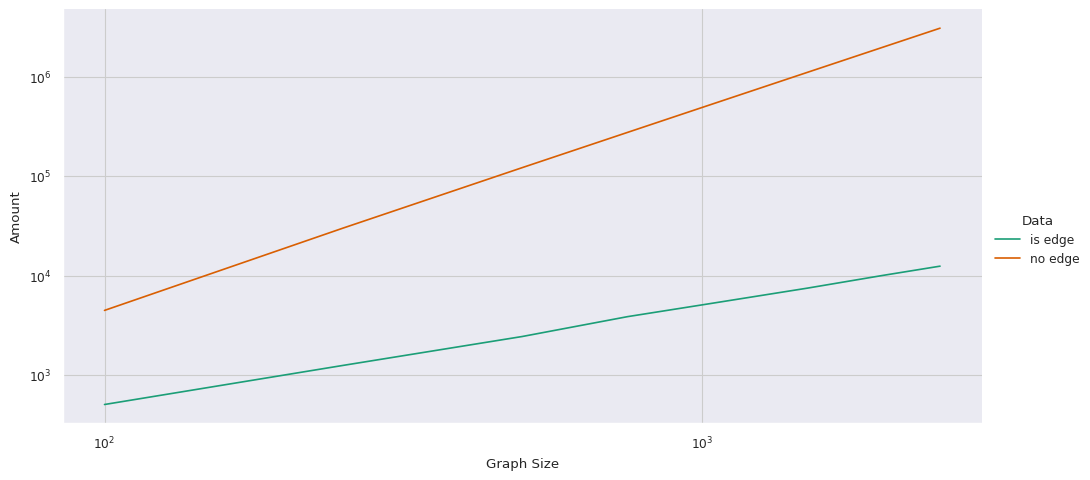

In [18]:
g = sns.relplot(
    data=df_result.assign(Data=df_result["type"].map({"n_non_edges": "no edge", "n_edges": "is edge"})), kind="line",
    # col="Data",
    hue="Data",
    x="graph_size",
    y="amount",
    errorbar="sd",
    palette=palette,
    aspect=2,
    facet_kws={
        'sharey': False,
        'sharex': True
    }
)
g.set_axis_labels("Graph Size", "Amount")
plt.yscale("log")
plt.xscale("log")
# for item, ax in g.axes_dict.items():
#     ax.set_title("")
g.fig.savefig('./out/dataset_composition_girg.pdf')

In [ ]:
df_result.to_csv(f"./out/data_girg.csv.zip", index=False, compression=dict(method='zip', archive_name=f"data_girg.csv"))

In [ ]:
df_result.assign(Data=df_result["type"].map({"n_non_edge": "no edge", "n_edge": "is edge"}))

In [ ]:
df_result.assign(type=df_result["type"].map({"n_non_edges": "no edge", "n_edges": "is edge"}))["type"]

# Subgraph Characteristics

In [5]:
sub_args = [
    Args(
        graph_size=graph_size,
        epoch_graph_size=epoch_graph_size,
        epoch_graph_alpha=epoch_graph_alpha
    )
    for graph_size in [500, 1000, 2500]
    for epoch_graph_size in [50, 100, 250]
    for epoch_graph_alpha in [0.0, 0.5, 1.0]
]
reps = 10
experiment_key = datetime.now().strftime("%d-%m--%H-%M")

def graph_char(_graph: nx.Graph) -> dict:
    n = nx.number_of_nodes(_graph)
    e = nx.number_of_edges(_graph)
    return {
        "n_nodes": n,
        "n_edges": e,
        "edge_imbalance": 2 * e / (n * (n - 1)),
        "n_cliques": nx.number_of_cliques(_graph),
        "n_isolates": nx.number_of_isolates(_graph),
        "n_components": nx.number_connected_components(_graph),
        "connected": nx.is_connected(_graph),
        "transitivity": nx.transitivity(_graph),
        "average_clustering": nx.average_clustering(_graph),
        "average_degree": np.array([d for n, d in _graph.degree()]).sum() / nx.number_of_nodes(_graph),
    }

df_graphs = pd.DataFrame({})

for i, args in enumerate(sub_args):
    print(f"running {i}/{len(sub_args)}")

    graph, dim = gen_graph(args)
    df_graphs = pd.concat([
        df_graphs,
        pd.Series({
            # graph and subgraph chars
            "target": "graph",
            **graph_char(graph),
            # run args
            "args_i": i,
            **asdict(args),
        }).to_frame().T
    ], ignore_index=True)

    for rep in range(reps):
        sub, _ = subgraph(
            graph=graph,
            size=args.epoch_graph_size,
            alpha=args.epoch_graph_alpha,
            boredom_pth=0.8,
        )
        df_graphs = pd.concat([
            df_graphs,
            pd.Series({
                # graph and subgraph chars
                "target": "subgraph",
                **graph_char(sub),
                # run args
                "args_i": i,
                "rep": rep,
                **asdict(args),
            }).to_frame().T
        ], ignore_index=True)

        df_graphs.to_csv(f"./run-data/sub--{experiment_key}.csv.zip", index=False, compression=dict(method='zip', archive_name=f"sub--{experiment_key}.csv"))
print("done")

running 0/27
running 1/27
running 2/27
running 3/27
running 4/27
running 5/27
running 6/27
running 7/27
running 8/27
running 9/27
running 10/27
running 11/27
running 12/27
running 13/27
running 14/27
running 15/27
running 16/27
running 17/27
running 18/27
running 19/27
running 20/27
running 21/27
running 22/27
running 23/27
running 24/27
running 25/27
running 26/27
done


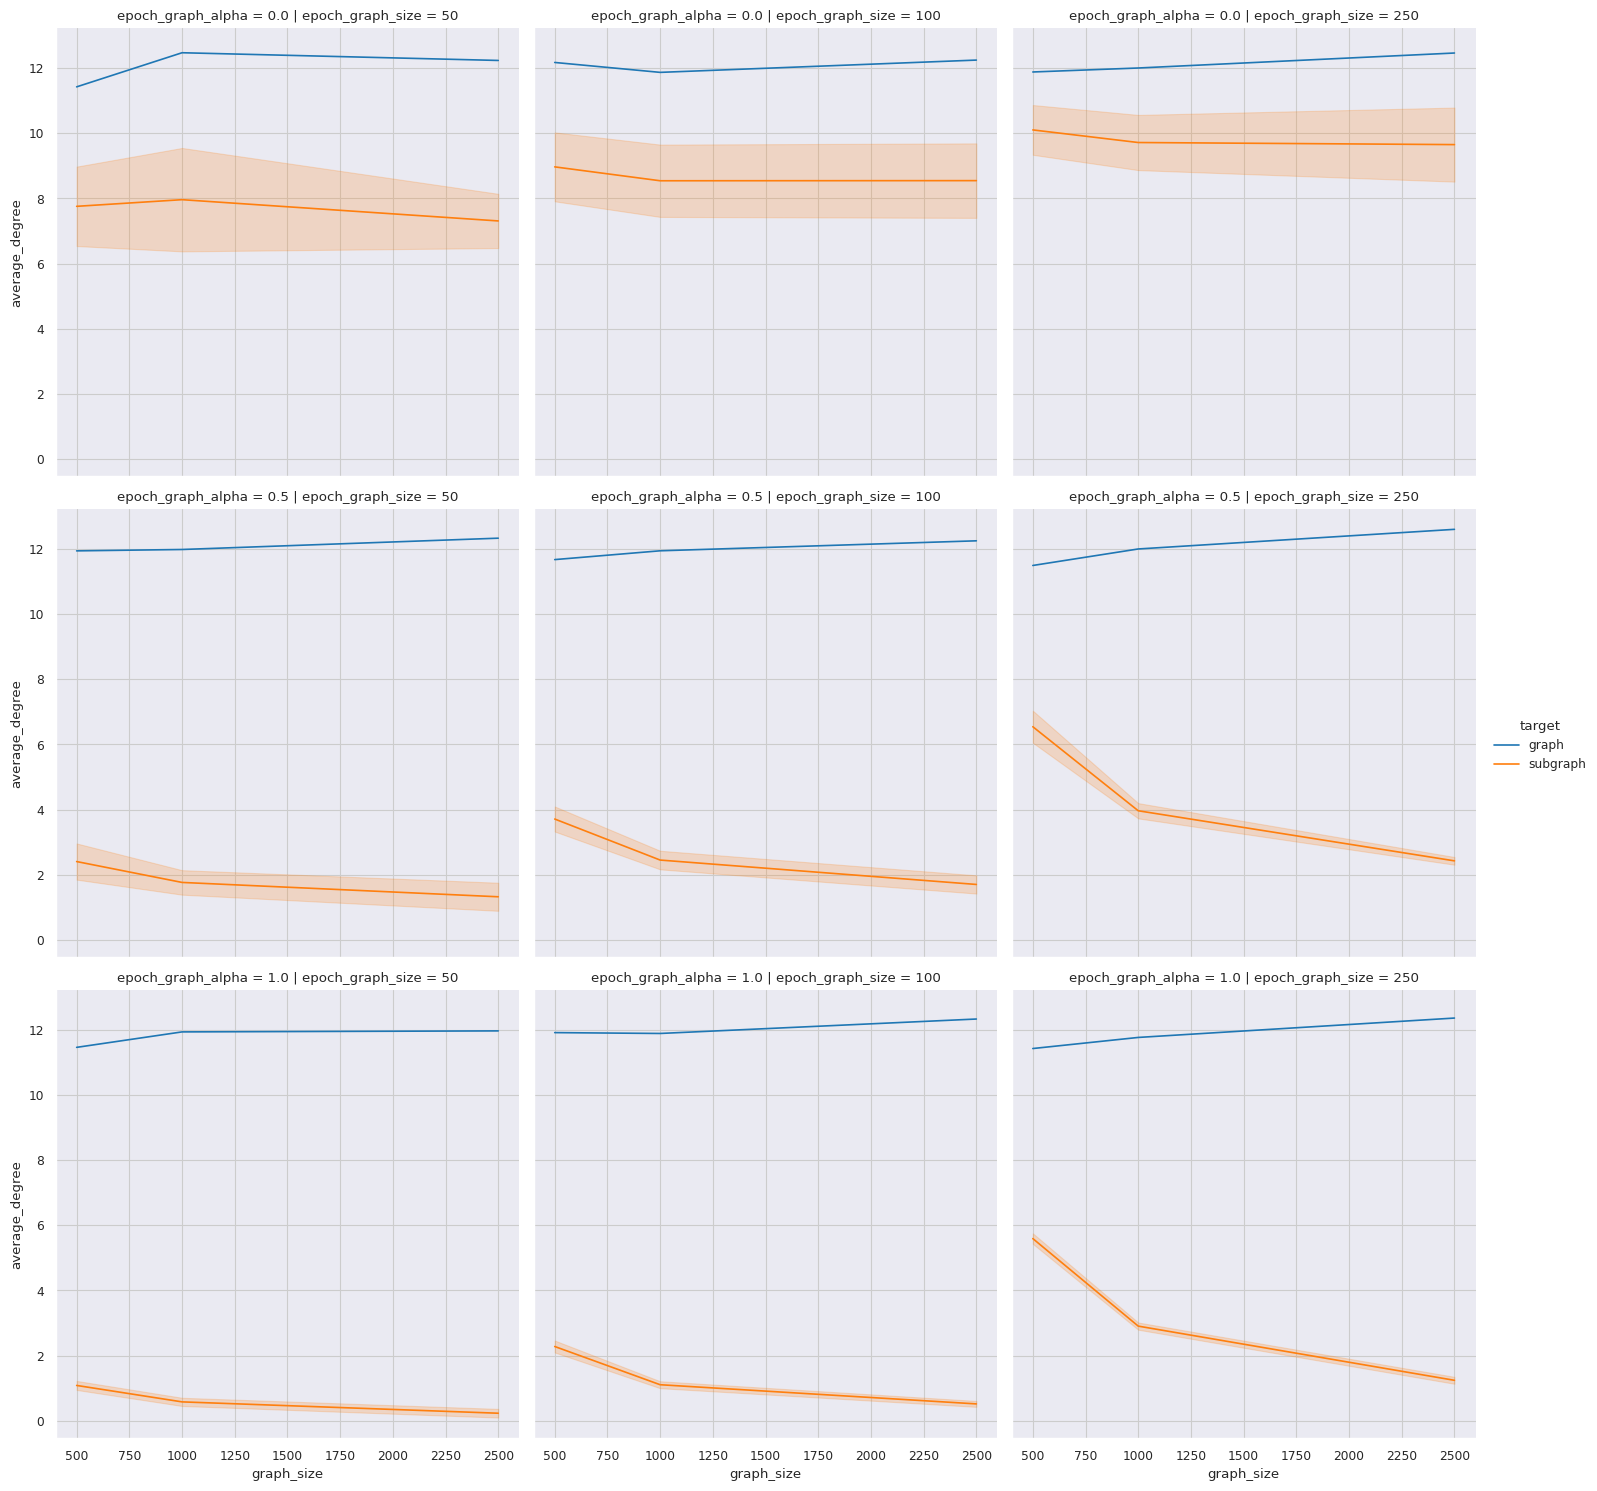

In [6]:
# plot grid search result "average_degree"
g = sns.relplot(
    data=df_graphs,
    x="graph_size",
    y="average_degree",
    hue="target",
    col="epoch_graph_size",
    row="epoch_graph_alpha",
    kind="line",
    errorbar="sd",
)
g.fig.savefig('./out/sub_chars.svg')

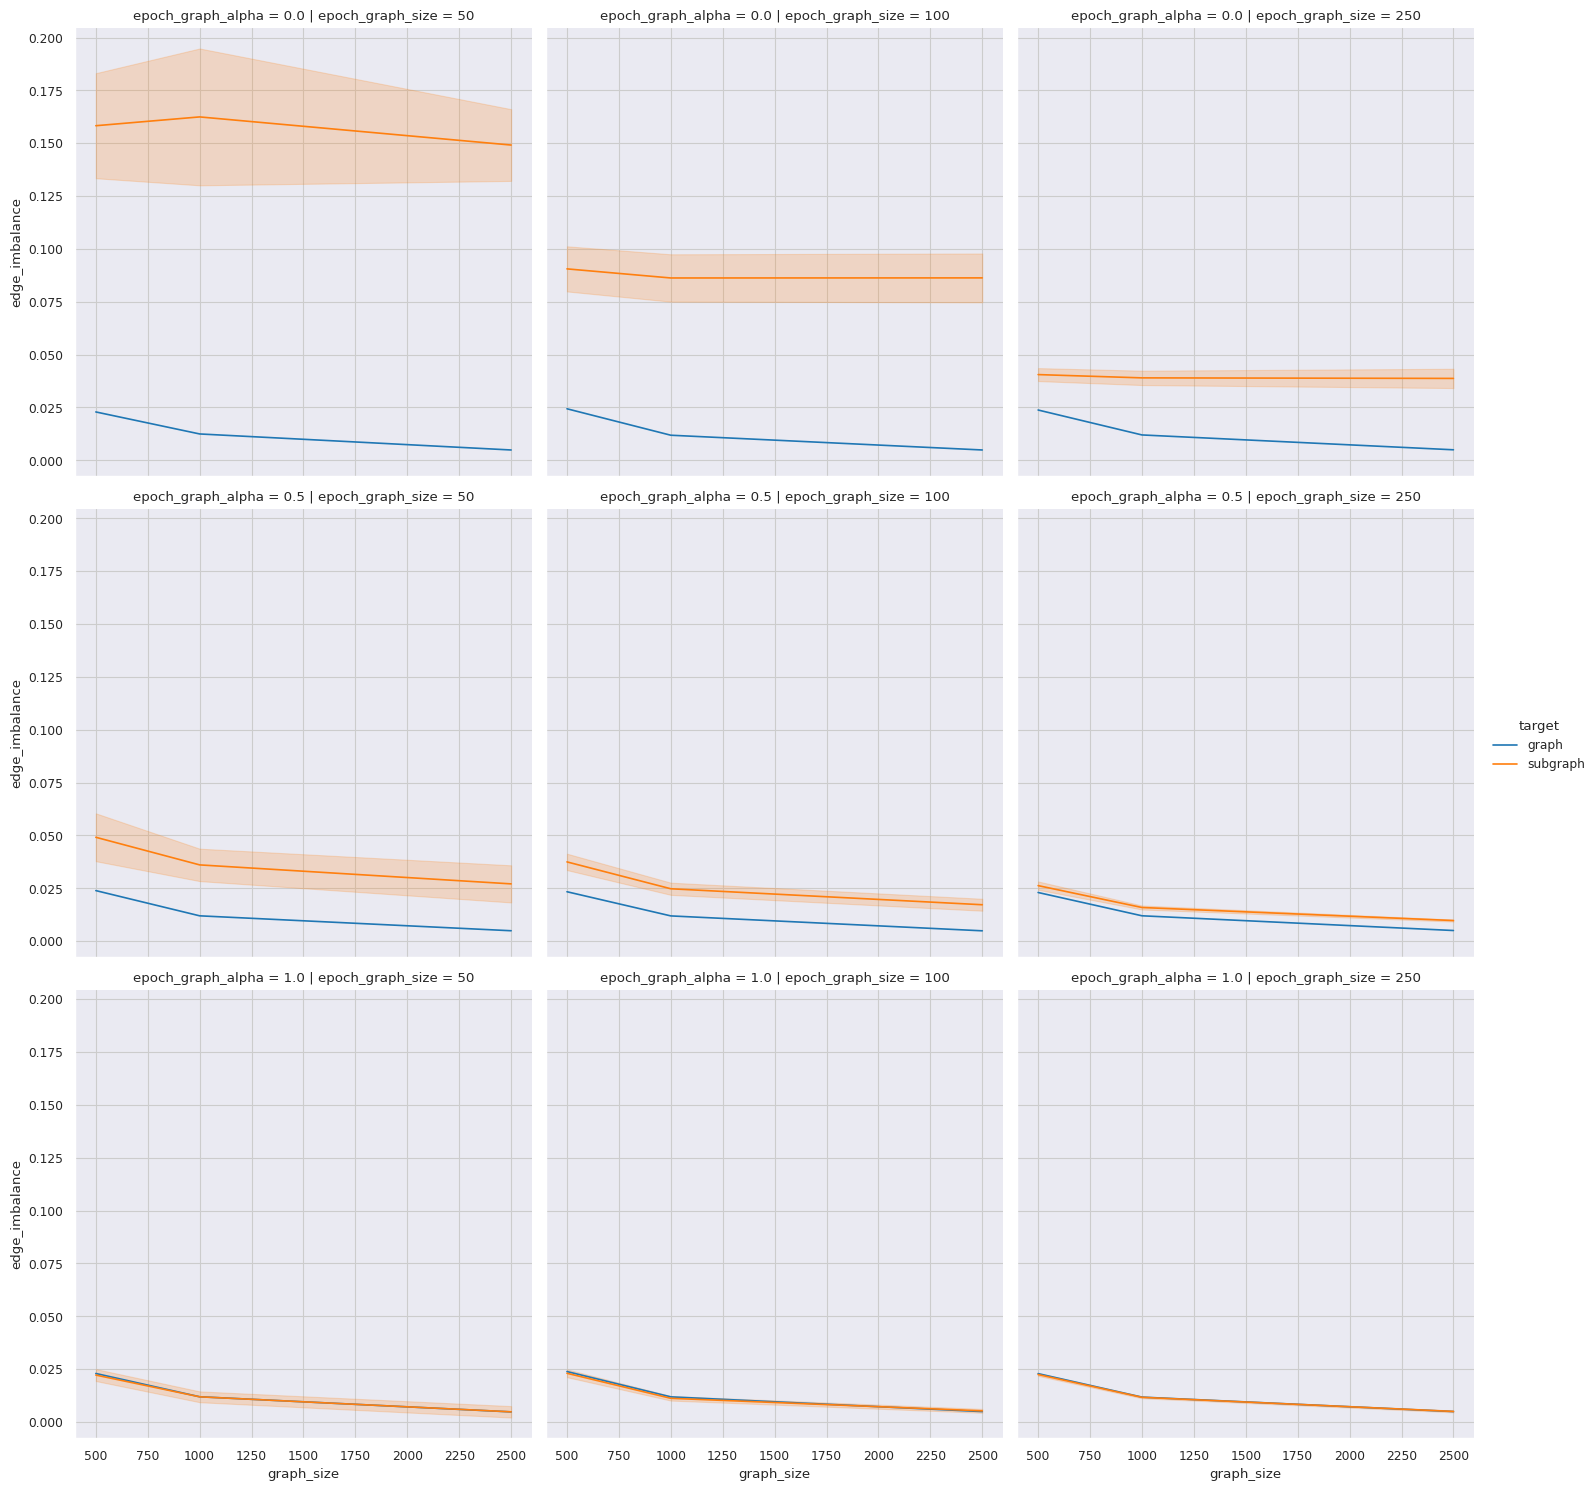

In [7]:
# plot grid search result "edge_imbalance"
g = sns.relplot(
    data=df_graphs,
    x="graph_size",
    y="edge_imbalance",
    hue="target",
    col="epoch_graph_size",
    row="epoch_graph_alpha",
    kind="line",
    errorbar="sd",
)
g.fig.savefig('./out/edge_imbalance.svg')
g.fig.savefig('./out/edge_imbalance.png')